In [7]:
import obspy
import numpy as np
import pandas as pd
from myFormat.data_format import para_struct
from seisflows.tools.graphics import _convert_to_array
from scipy.interpolate import interp1d

## for ploting
import matplotlib.pyplot as plt 
from seisflows.tools.graphics import plot_section

import argparse


# for filtering
from obspy.signal.filter import bandpass


#### for spectrum plotting
from scipy import signal
#from obspy.signal.util import _npts2nfft
#from obspy.signal.invsim import cosine_sac_taper
from scipy.fftpack import fft, ifft, fftfreq

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
## for i/o
#from obspy import read
import scipy.io as sio 
from obspy.core.stream import Stream
import os  

stream_obs = read('obf/input/Up_gaussian.su',format='SU', byteorder='<')
data_obs = _convert_to_array(stream_obs)
print('the shape of the observed data: ', data_obs.shape)
stream_syn = read('obf/input/Up_ricker.su',format='SU', byteorder='<')
data_syn = _convert_to_array(stream_syn)

trace_num = 0 

trace_obs = data_obs[:,trace_num]
print('shape of observed is :', trace_obs.shape)
trace_syn = data_syn[:,trace_num]
print('shape of synthetic signal is :', trace_syn.shape)


('the shape of the observed data: ', (5000, 360))
('shape of observed is :', (5000,))
('shape of synthetic signal is :', (5000,))


In [9]:
stf_syn_pd = pd.read_csv('obf/input/stf_ricker.txt',header=None,delim_whitespace=True)
stf_syn_1Dnp = stf_syn_pd.values
stf_syn = stf_syn_1Dnp[:,1]
stf_obs_1Dnp = pd.read_csv('obf/input/stf_gaussian.txt',header=None,delim_whitespace=True).values
stf_obs = stf_obs_1Dnp[:,1]


In [10]:
# create a class of structure that can be used to store parameters for 
from myFormat.data_format import para_struct
exp_para = para_struct('exp_para')
# load all parameters: 

f0=500000; exp_para.f0 = f0
fmax = 1000000; exp_para.fmax = fmax
#output_time_step = 20000; exp_para.output_time_step = output_time_step;
dt = 4e-9; exp_para.dt = dt
#DownSampleFact=8; exp_para.DownSampleFact = DownSampleFact;
dtNew = dt; exp_para.dtNew = dtNew;

#%%% about the filters 
half_width=400000; exp_para.half_width = half_width;
low_freq=100000; exp_para.low_freq = low_freq;
high_freq=900000; exp_para.high_freq = high_freq;
band=[low_freq,high_freq]; exp_para.band = band;
nyq_freq=2.5e7; exp_para.nyq_freq = nyq_freq;
N=50000; exp_para.N = N;




In [11]:
#SOURCE_SIGNAL_MATRIX=para.SOURCE_SIGNAL_MATRIX;

##%%% 
#%rawdata = para.rawdata;
Nt=5000; exp_para.Nt = Nt; 
#Na=20250; exp_para.Na = Na; 
NSrc=1; exp_para.NSrc = NSrc; 
NRec=360; exp_para.NRec = NRec;


In [12]:
# load the received signal from the transducer

t_total = np.arange(dtNew,Nt*dtNew+dtNew,dtNew)
exp_para.t_total = t_total
#t_cut = np.arange(dtNew,output_time_step*dtNew+dtNew,dtNew)
#exp_para.t_cut = t_cut
t_cut = t_total
exp_para.t_cut = t_cut

sample_total = np.arange(1,Nt+1,1)
#sample_cut = np.arange(1,output_time_step+1,1)
sample_cut  = sample_total

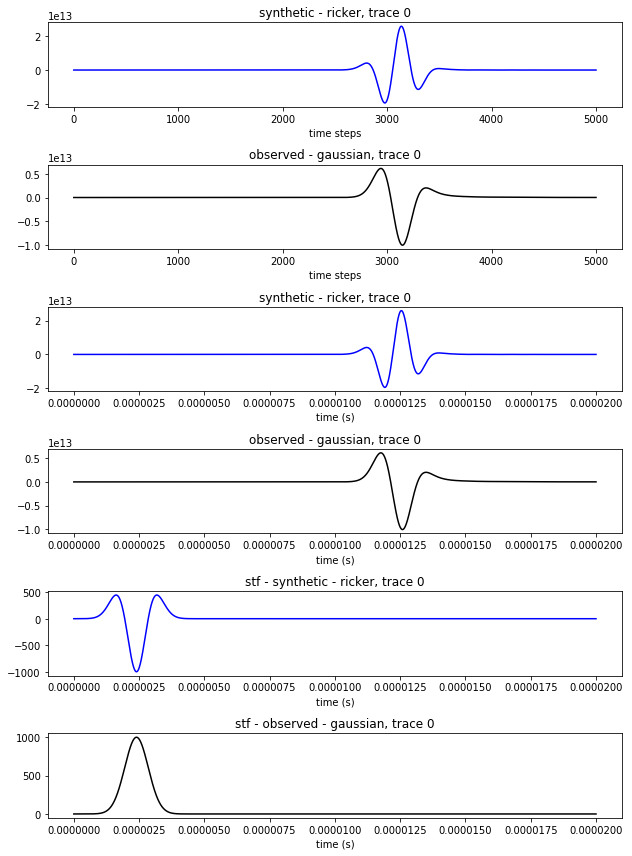

In [40]:
1.1 # plot the received signals
t_star_show = 0
t_end_show = Nt


fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=6)

ax0.plot(sample_total[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax0.set_title('synthetic - ricker, trace ' + str(trace_num))
ax0.set_xlabel('time steps')

ax1.plot(sample_total[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax1.set_title('observed - gaussian, trace ' + str(trace_num))
ax1.set_xlabel('time steps')

ax2.plot(t_total[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax2.set_title('synthetic - ricker, trace ' + str(trace_num))
ax2.set_xlabel('time (s)')

ax3.plot(t_total[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax3.set_title('observed - gaussian, trace ' + str(trace_num))
ax3.set_xlabel('time (s)')

ax4.plot(t_total[t_star_show:t_end_show],stf_syn[t_star_show:t_end_show],'b-')
ax4.set_title('stf - synthetic - ricker, trace ' + str(trace_num))
ax4.set_xlabel('time (s)')

ax5.plot(t_total[t_star_show:t_end_show],stf_obs[t_star_show:t_end_show],'k-')
ax5.set_title('stf - observed - gaussian, trace ' + str(trace_num))
ax5.set_xlabel('time (s)')

plt.tight_layout(rect=[0, 0, 1.5, 3])
fig.show()

### 1.2 zero padding for reliable FFT

In [42]:
import math as M
from future.utils import native
def next_pow_2(i):
    """
    Find the next power of two

    >>> int(next_pow_2(5))
    8
    >>> int(next_pow_2(250))
    256
    """
    # do not use NumPy here, math is much faster for single values
    buf = M.ceil(M.log(i) / M.log(2))
    return native(int(M.pow(2, buf)))

# signal filtering


fs=1./dt
print('original sampling frequency in experimental data (not used): %f Hz' % fs)
fs_new=1./dtNew
print('new sampling frequency after resampling: %f Hz' % fs_new)

nfft = next_pow_2(Nt)
print('zero-padded length of fft: %d ' % nfft)

#df_new = int(round(fs_new/nfft))
#print(df_new_round)
df_new = (fs_new/Nt)
df_new_pad = (fs_new/nfft)

print('frequency intervel before zero-padding: %f Hz ' % df_new)
print('frequency intervel after zero-padding: %f Hz (actually used)' % df_new_pad)


original sampling frequency in experimental data (not used): 250000000.000000 Hz
new sampling frequency after resampling: 250000000.000000 Hz
zero-padded length of fft: 8192 
frequency intervel before zero-padding: 50000.000000 Hz 
frequency intervel after zero-padding: 30517.578125 Hz (actually used)


In [45]:
### 1.3 calculate the frequency spectrum for original signals 
freq_show_star = 40000
freq_show_end = 8000000

freq_step_star = int(round(freq_show_star/df_new))
print(freq_step_star)
freq_step_end = int(round(freq_show_end/df_new)) 
print(freq_step_end)

xf = np.linspace(0.0, fs_new, nfft)

1
160


### multiple Gaussian signals and their spectrum

In [14]:
 
fig = plt.figure()

#fig, axes = plt.figure()

for i in range(num_rec):
#for ax in range(num_rec):
    #fig,ax = plt.figure()
    col_num = mat_rec_plot[i]
    #titlename = fhead + ' receiver: %d ' % (col_num)
    titlename = ' source: %d receiver: %d amp_factor:%f' % (act_to_plot,col_num,amp_factor)
    #fig, ax = plt.subplot(num_rec, 1, i+1)
    ax = fig.add_subplot(num_rec, 1, i+1)
    if flag_seismotype != 4:
       ax.plot(t, Ux_data[time_step_star:time_step_comp,col_num], 'b-',label='Ux')
       ax.plot(t, Uz_data[time_step_star:time_step_comp,col_num], 'g-',label='Uz')
    ax.plot(t, Un_data[time_step_star:time_step_comp,col_num], 'm-',label='Un')
    ax.plot(t, amp_factor*Ue_data[time_step_star:time_step_comp,col_num], 'r-',label='Ue')
    ax.hold(True)
       
    ax.set_title(titlename)
    ax.legend(loc='right')

NameError: name 'amp_factor' is not defined

In [21]:
import glob
OUTPUT_FILES_path = "obf/output"
INPUT_path = "obf/input"
stffilenamelist = glob.glob(INPUT_path + '/' + "stf_*")


In [30]:

len(stffilenamelist)

8

fhead is 1000000
obf/input/stf_f0_1000000
fhead is 10000000
obf/input/stf_f0_10000000
fhead is 2000000
obf/input/stf_f0_2000000
fhead is 3000000
obf/input/stf_f0_3000000
fhead is 4000000
obf/input/stf_f0_4000000
fhead is 5000000
obf/input/stf_f0_5000000
fhead is 6000000
obf/input/stf_f0_6000000


/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


fhead is 7000000
obf/input/stf_f0_7000000
fhead is 8000000
obf/input/stf_f0_8000000
fhead is 9000000
obf/input/stf_f0_9000000


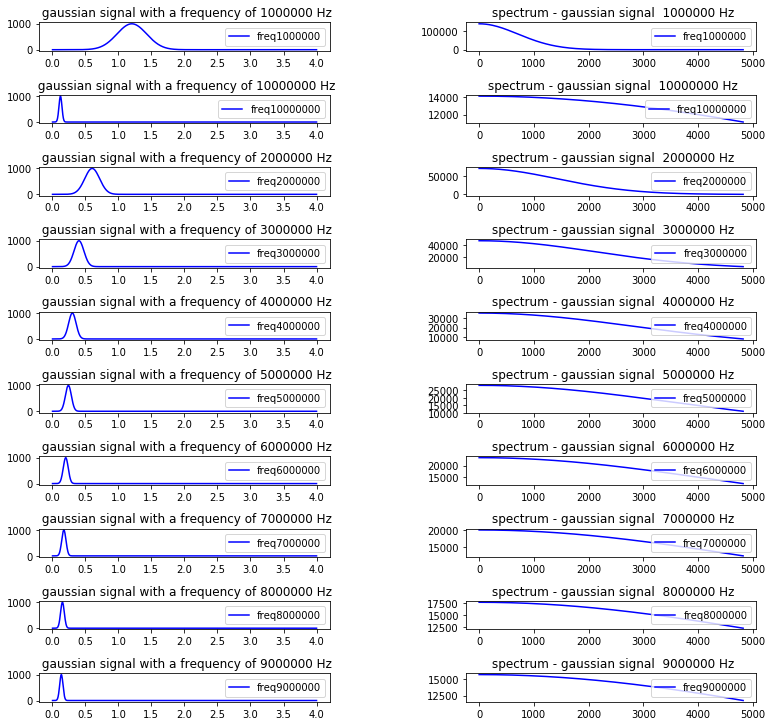

In [58]:
import glob
OUTPUT_FILES_path = "obf/output"
INPUT_path = "obf/input"
stffilenamelist = glob.glob(INPUT_path + '/' + "stf_*")



fig = plt.figure()
i=0
for fname in stffilenamelist:
    
    #fname = pd.read_csv('obf/input/stf_gaussian.txt',header=None,delim_whitespace=True).vals
    fhead=(fname[len(INPUT_path)+8:])
    print('fhead is '+fhead)
    print(fname)
    stf_gaussian_1Dnp = pd.read_csv(fname,header=None,delim_whitespace=True).values
    stf_gaussian = stf_gaussian_1Dnp[:,1]
    titlename = ' gaussian signal with a frequency of %s Hz' % (fhead)
    ax = fig.add_subplot(2*len(stffilenamelist), 2, i+1)
    
    ax.plot(t_total[t_star_show:len(stf_gaussian)]*1e6,stf_gaussian[t_star_show:], 'b-',label='freq'+fhead)
    ax.hold(True)
       
    ax.set_title(titlename)
    ax.legend(loc='right')
    i=i+1
    yf_stf = fft(stf_gaussian[0:Nt], axis=0, n=nfft)
    titlename = ' spectrum - gaussian signal  %s Hz' % (fhead)
    ax = fig.add_subplot(2*len(stffilenamelist), 2, i+1)
    ax.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf[freq_step_star-1:freq_step_end-1]), 'b-',label='freq'+fhead)
    ax.hold(True)
    
    ax.set_title(titlename)
    ax.legend(loc='right')
    i=i+1
    
plt.tight_layout(rect=[0, 0, 2, 5])
fig.show()    

str

In [ ]:

stf_obs_1Dnp = pd.read_csv('obf/input/stf_gaussian.txt',header=None,delim_whitespace=True).values
stf_obs = stf_obs_1Dnp[:,1]

